# Imports


In [1]:
import sys
sys.path.append("../lib")
import em2d as zpic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import math
matplotlib.rcParams["figure.figsize"] = (12, 8)

# Noramalization in ZPIC


The normalization in ZPIC is done by choosing a reference normalization frequency, $\omega_n$. Using this, different units are noramlized by the formulae:

$$
\begin{align*}
x' &= \frac{\omega_n}{c} x\\
t' &= \frac{t}{\omega_n}\\
u' &= \frac{u}{c} = \frac{\gamma v}{c}\\
E' &= e \frac{c / \omega_n }{m_e c^2} E\\
B' &= e \frac{c / \omega_n }{m_e c^2} B
\end{align*}
$$


In the simulation, we will choose $\omega_n$ such as the plasma density is eqaul to $1$. This can be done by using the relation of plasma density:

$$
\omega_p = \sqrt{\frac{n_0e^2}{\epsilon_0 m}}
$$

Which simplifies to:

$$
\omega_p = 56.35\times \sqrt{n_0}
$$


# 6.1.1 Simulation of laser propagation in vacuum


## Parameters


### In Real Units


- Simulation Box: $20\:\mu m\times20\:\mu m\times50\:\mu m$
- Number of Cells: $200\times200\times500$
- Plasma Density: $n_0 = 10^{25} \: m^{-3}$
- Laser Intensity: $I = 2\times10^{22} \: Wm^{-2}$
- Laser Wavelength: $\lambda = 10^{-6} \: m$
- Particle Per Cell: $0$
- FWHM of the Laser: $1 \:\mu m$
- Width of the Laser: $2.5 \:\mu m$
- The laser propagates in z direction and is p-polarized, that is, the electric field vector of the laser oscillates along the y-axis.
- The laser starts at $(10\:\mu m\times10\:\mu m\times-2\:\mu m)$ which is the center of the xy-plane $2 \:\mu m$ in front of the
  simulation box.


### In Simulation Units


As $n_0=10^{25} \: m^{-3}$, the electron plasma frequency corresponding to this is

$$
\begin{align*}
\omega_n &= 56.35\times \sqrt{10^{25}} \: \mathrm{Hz}\\
&= 1.78\times 10^{14} \: \mathrm{Hz}
\end{align*}
$$


Using this we can calculate that $1 \:\mu m$ is equal to $0.593 \: \text{zpic unit}$


Now, the electric field of the laser is can be calculated using:

$$
I = \frac{1}{2}\epsilon_0 c E_0^2
$$

The electric field comes out to be $3.882\times 10^{12} \:\text{N/C}$. Noramlizing this to ZPIC unit gives a value of $12.77$.


Next, we'll calculate the frequency of the laser using its wavelength. Since $f = \frac{c}{\lambda}$, the frequency is (after multiplying with $2\pi$) $1.88\times 10^{15} \:\text{Hz}$. In ZPIC units, this is equal to $10.6$.


The laser propagates in z direction and is p-polarized, however, ZPIC supports only those lasers moving in x direction. Hence, we'll be changing the axes such that:

z -> x

x -> y

y -> z


In this way, the laser in propagating in x direction while the electric field vector of the laser oscillates along the z-axis, making an angle of $\pi/2$ with y-axis.


The final units are:

- Simulation Box: $12 \times12 \times30$
- Number of Cells: $200\times200\times500$
- Plasma Density `n0`: $1$
- Particle Per Cell `ppc`: $0$
- Normalized vector potential `a0`: $12.77$
- Laser frequency `omega0` : $10.6$
- FWHM of the Laser `fwhm` : $0.593$
- Width of the Laser `W0`: $1.48$
- Laser polarization in radians measured in reference to the y direction `polarization`: $\pi/2$


## Simulation


In [2]:
wn = 1.78e14
tmax = 150*wn/10**15
tmax

26.7

The simulation will run till 150 fs, which, in zpic unit, translates to: $26.7$


In [3]:
dt_max = ((30/500)**2+(12/200)**2)**0.5
dt_max

0.08485281374238571

In [28]:
box = [30.0, 12.0]
dt = 0.01
nx  = [ 500, 200 ]
tmax = 26.7

sim = zpic.Simulation( nx, box, dt)

In [29]:
laser = zpic.Laser( type = "plane", fwhm=1e-2, start = 1, a0 = 12.77/10.6, omega0 = 1, polarization = np.pi/2 , axis=6, rise=0.01, flat=26.7, fall=0.01 )
sim.add_laser(laser)

In [30]:
12.77/10.6

1.2047169811320755

In [31]:
sim.emf.Ez.max()

0.0

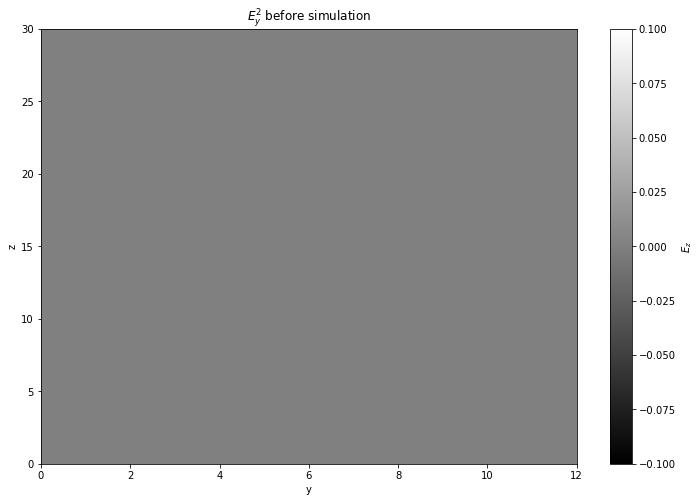

In [32]:
boundary = [[0,sim.box[1]],[0,sim.box[0]]]
plt.imshow( (sim.emf.Ez.T)**2, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')
plt.colorbar().set_label('$E_z$')
plt.xlabel("y")
plt.ylabel("z")
plt.title("$E_y^2$ before simulation")
plt.show()

In [33]:
tdump = 100
max_time = math.ceil(tmax/(dt*tdump))
ezs = np.zeros((max_time, nx[1], nx[0]))
eys = np.zeros((max_time, nx[1], nx[0]))
exs = np.zeros((max_time, nx[1], nx[0]))
times = ["1.00", "5.87", "8.40", "11.75", "17.80", "23.67"]
ezs_time = np.zeros((len(times), nx[1], nx[0]))

j = 0
for t in range(int(tmax/dt)):
    print(f"t = {t*dt:.2f} of {tmax}", end = "\r")
    sim.iter()
    if t % tdump == 0:
        ezs[t//tdump,:,:] = sim.emf.Ez
        eys[t//tdump,:,:] = sim.emf.Ey
        exs[t//tdump,:,:] = sim.emf.Ex
    if f"{t*dt:.2f}" in times:
        ezs_time[j,:,:] = sim.emf.Ez
        j += 1

In [34]:
eys.max(), eys.min()

(6.1575180509976235e-09, -6.1575180509976235e-09)

In [35]:
ezs.max(), ezs.min()

(0.14086756110191345, -0.14086756110191345)

In [36]:
time_new = np.linspace(0, tmax, max_time)/wn*1e15
time_new

array([  0.        ,   5.76923077,  11.53846154,  17.30769231,
        23.07692308,  28.84615385,  34.61538462,  40.38461538,
        46.15384615,  51.92307692,  57.69230769,  63.46153846,
        69.23076923,  75.        ,  80.76923077,  86.53846154,
        92.30769231,  98.07692308, 103.84615385, 109.61538462,
       115.38461538, 121.15384615, 126.92307692, 132.69230769,
       138.46153846, 144.23076923, 150.        ])

In [37]:
5e-5/3e8

1.6666666666666667e-13

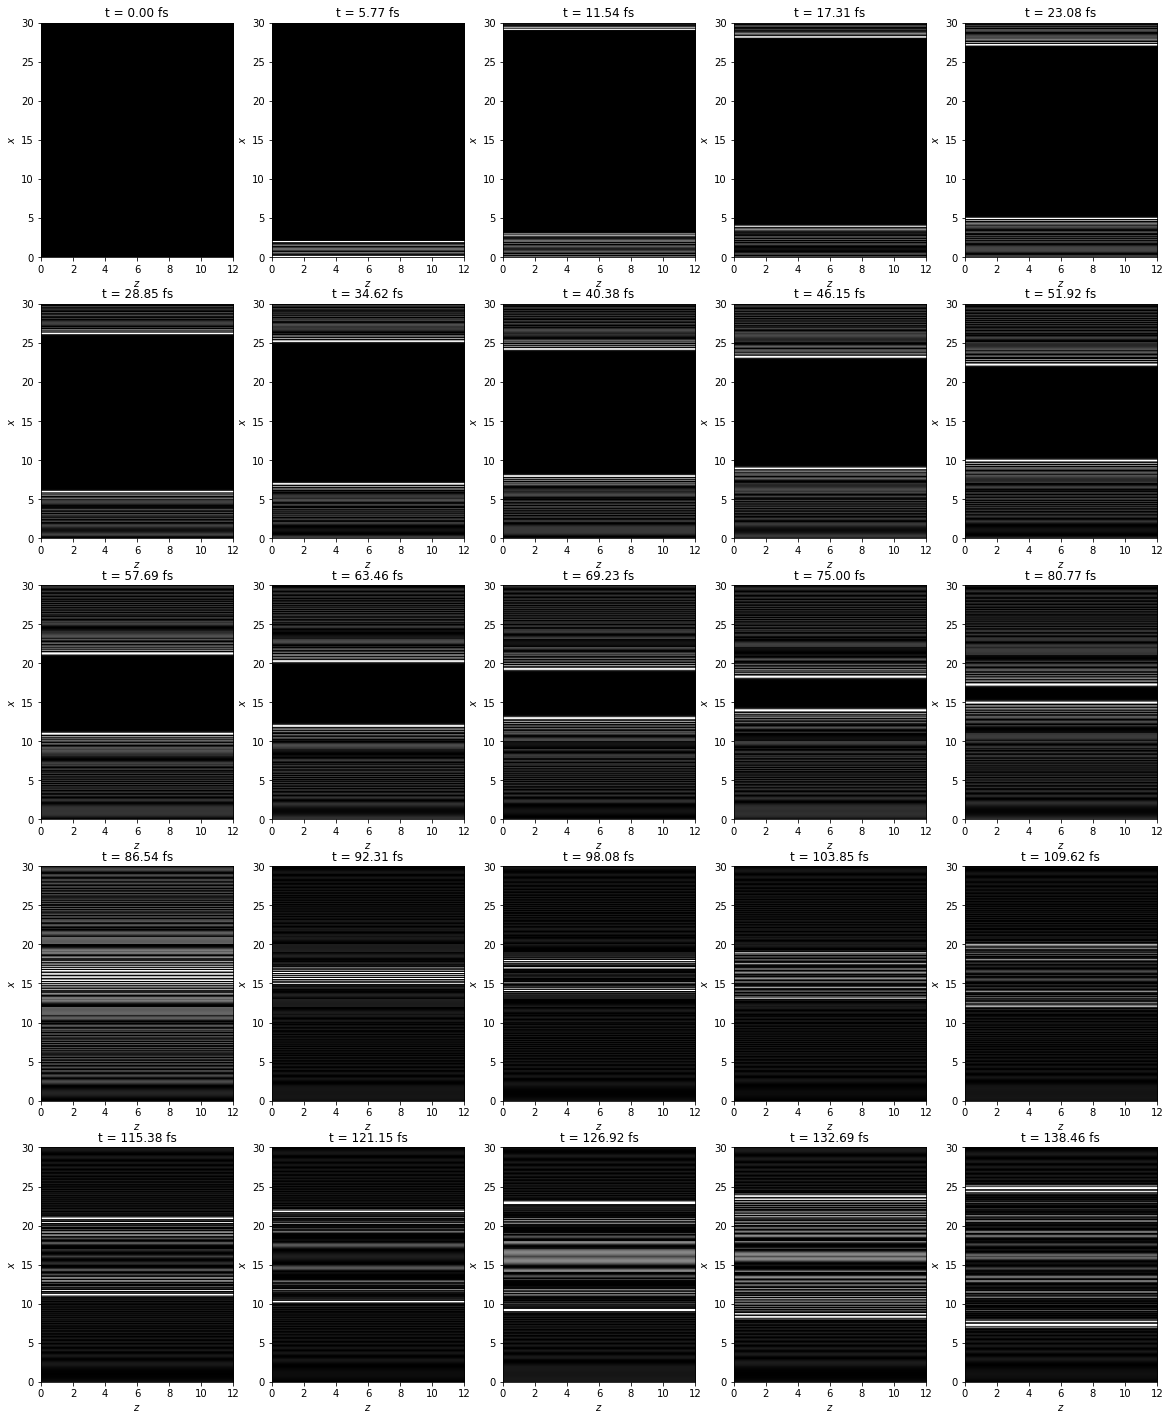

In [38]:
fig, axs = plt.subplots(5,5)
fig.set_size_inches(20,25)
for i in range(25):
    row = i//5
    col = i%5
    ax = axs[row,col]
    ax.imshow( ezs[i].T**2, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray',
        #     norm=colors.Normalize(vmin=0.0, vmax=0.05)
            )
    ax.set_xlabel("$z$")
    ax.set_ylabel("$x$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")


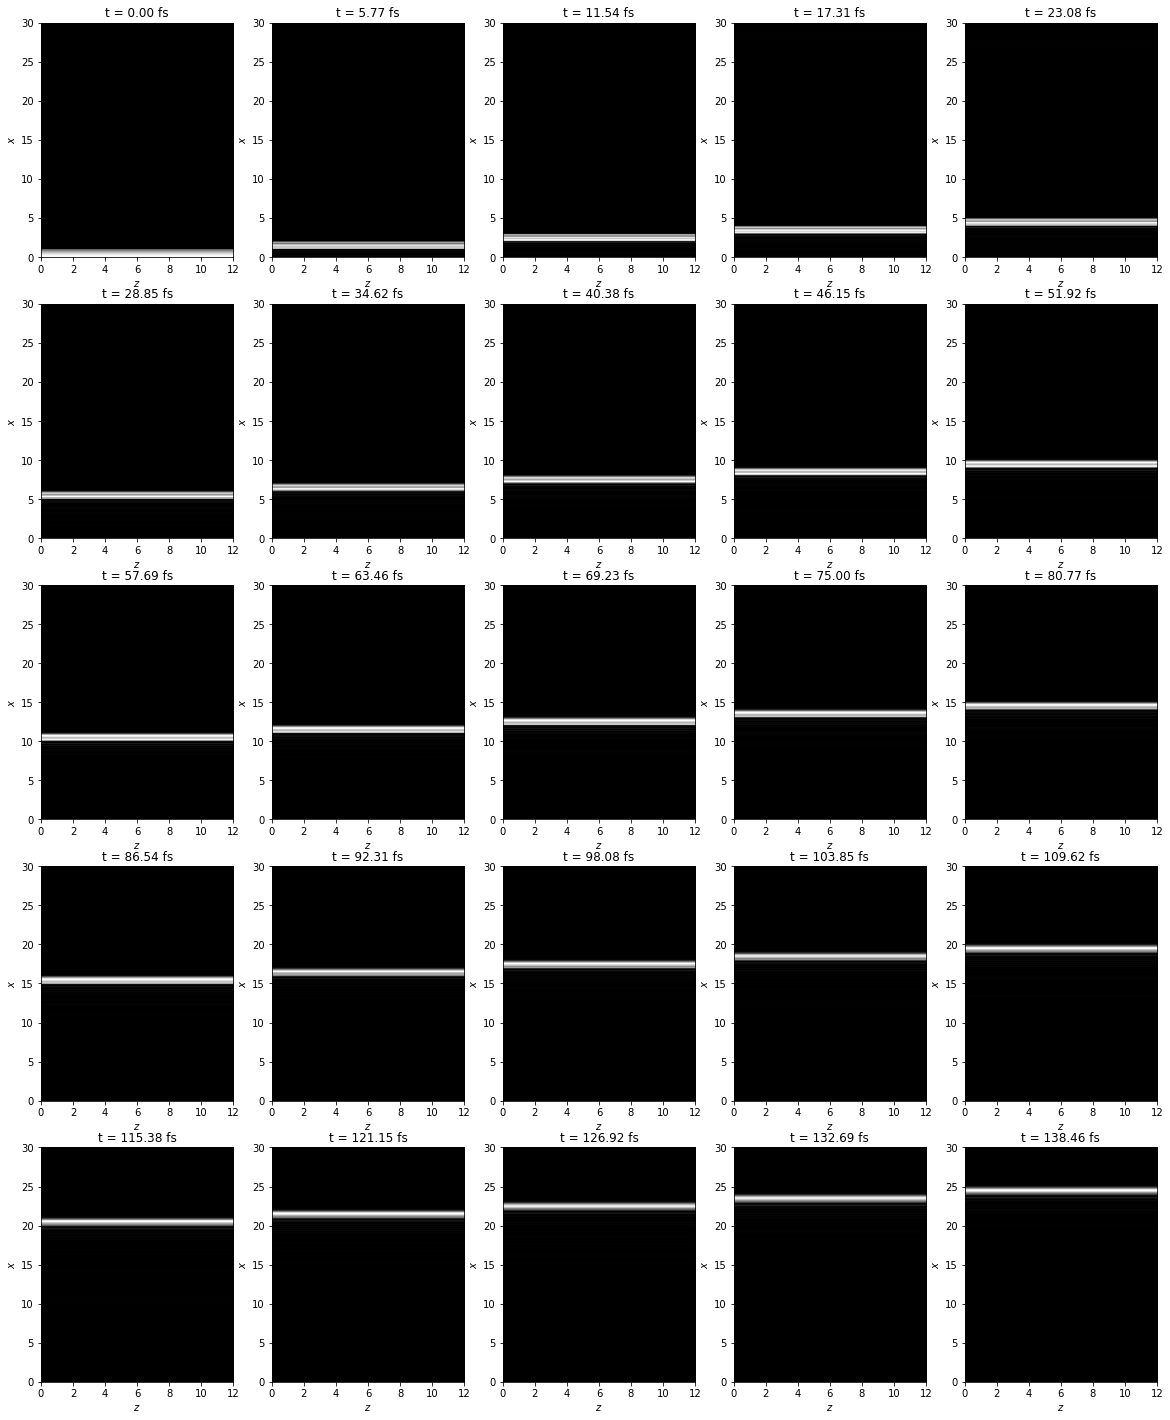

In [13]:
fig, axs = plt.subplots(5,5)
fig.set_size_inches(20,25)
for i in range(25):
    row = i//5
    col = i%5
    ax = axs[row,col]
    ax.imshow( eys[i].T**2, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray',
            # norm=colors.Normalize(vmin=0.0, vmax=0.05)
            )
    ax.set_xlabel("$z$")
    ax.set_ylabel("$x$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")


In [62]:
exs.max(), exs.min()

(9.874812126159668, -9.874812126159668)

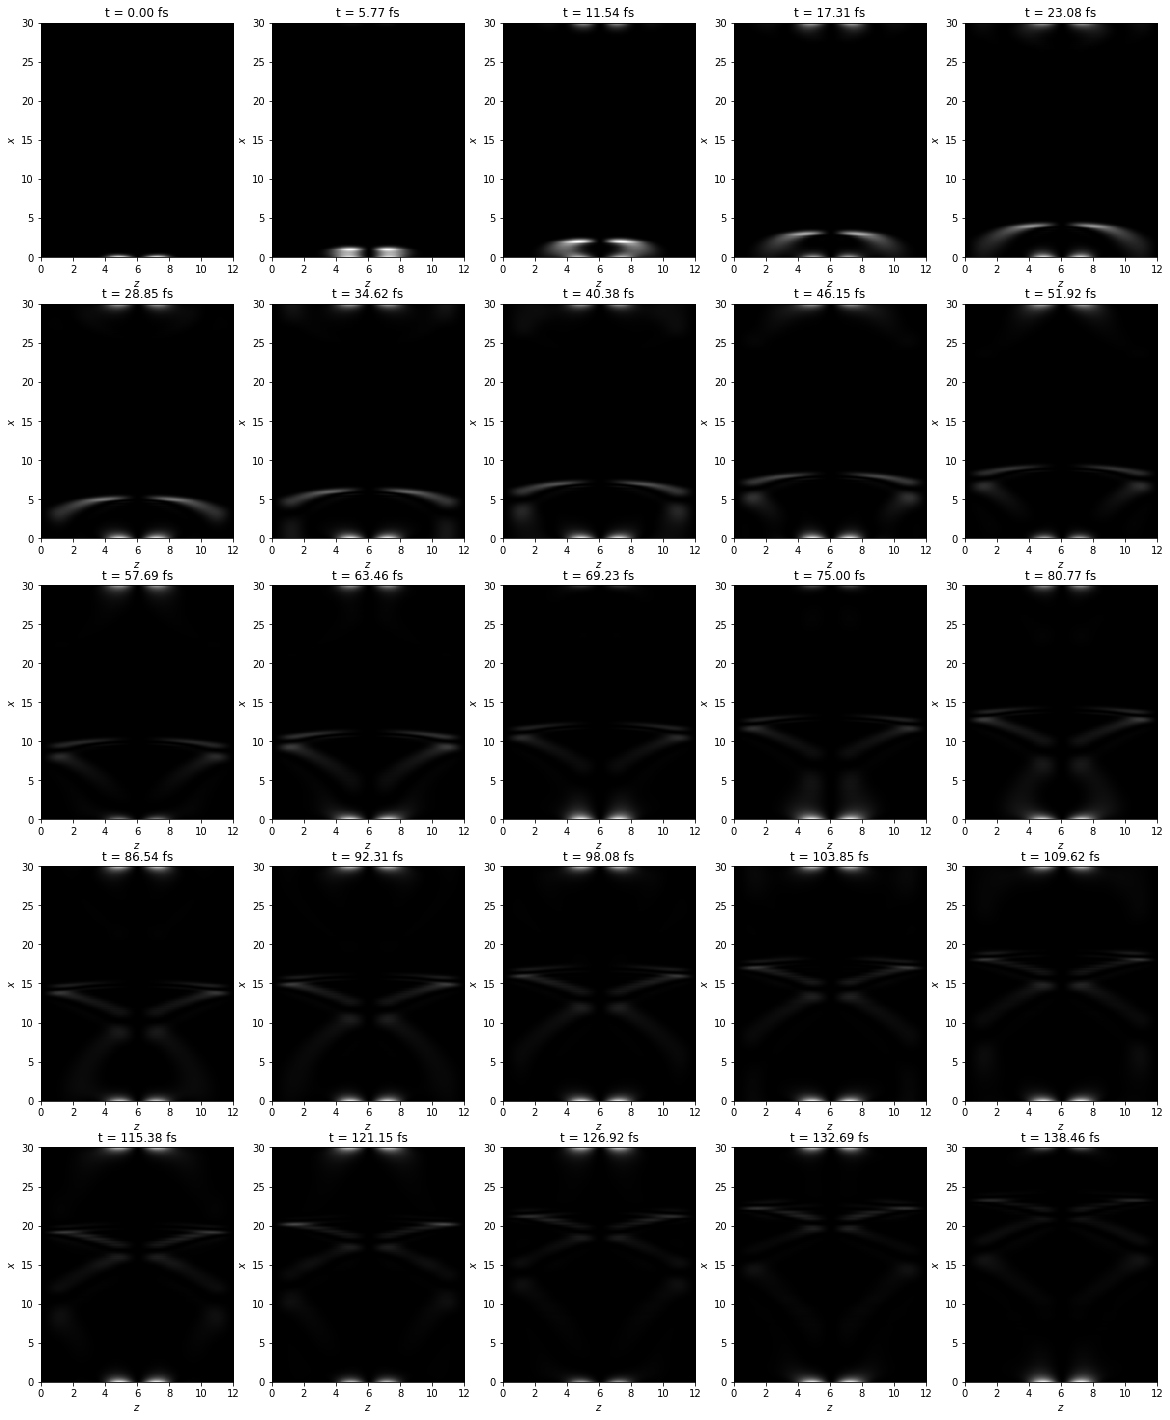

In [16]:
fig, axs = plt.subplots(5,5)
fig.set_size_inches(20,25)
for i in range(25):
    row = i//5
    col = i%5
    ax = axs[row,col]
    ax.imshow( exs[i].T**2, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray',
        #     norm=colors.Normalize(vmin=0.0, vmax=0.05)
            )
    ax.set_xlabel("$z$")
    ax.set_ylabel("$x$")
    ax.set_title(f"t = {time_new[i]:.2f} fs")


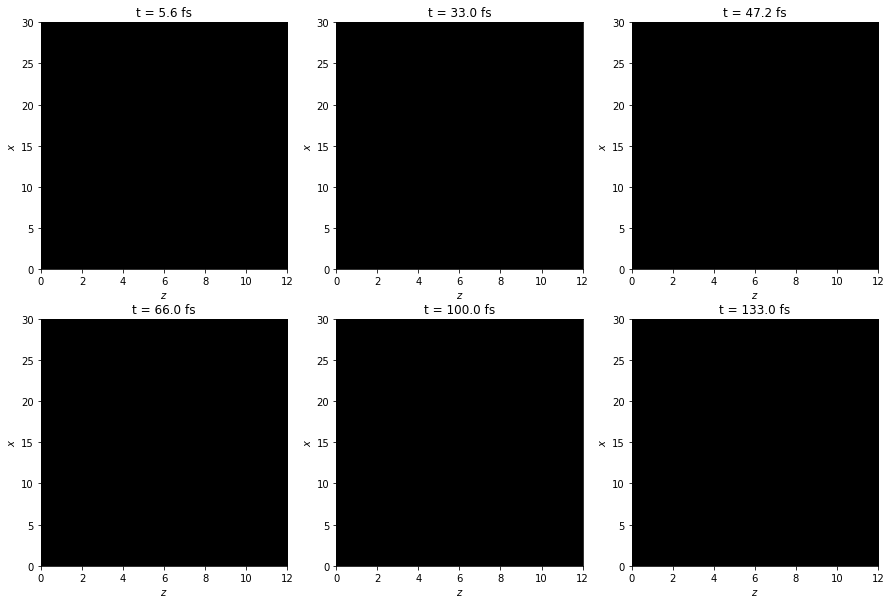

In [64]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,10)
times = ["1.00", "5.87", "8.40", "11.75", "17.80", "23.67"]
times = [float(t)/wn*1e15 for t in times]
for i in range(6):
    row = i//3
    col = i%3
    ax = axs[row,col]
    ax.imshow( ezs_time[i].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')
    ax.set_xlabel("$z$")
    ax.set_ylabel("$x$")
    ax.set_title(f"t = {times[i]:.1f} fs")


In [65]:
(ezs[0].max()**2+exs[0].max()**2+eys[0].max()**2)**0.5

105.8536483416047

In [22]:
def plot_for_time(time):

    plt.imshow( ezs_time[time].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')

    plt.colorbar().set_label('$E_z$')
    plt.xlabel("$z$")
    plt.ylabel("$x$")
    plt.title(f"Laser Field at\nt = {times[time]}")

    plt.show()

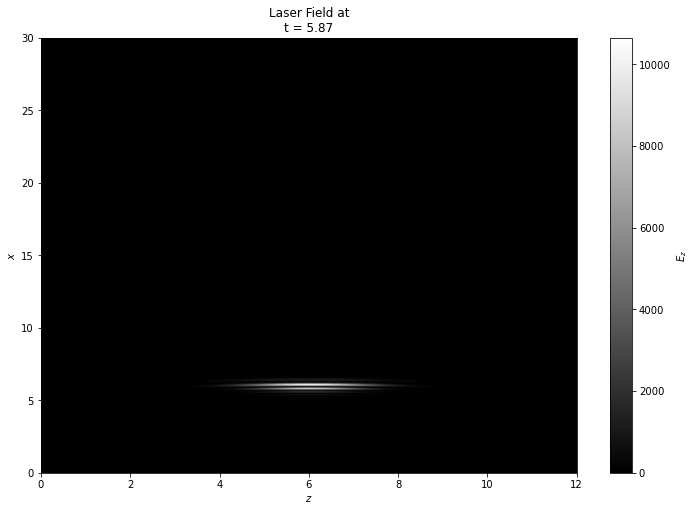

In [23]:
plot_for_time(1)

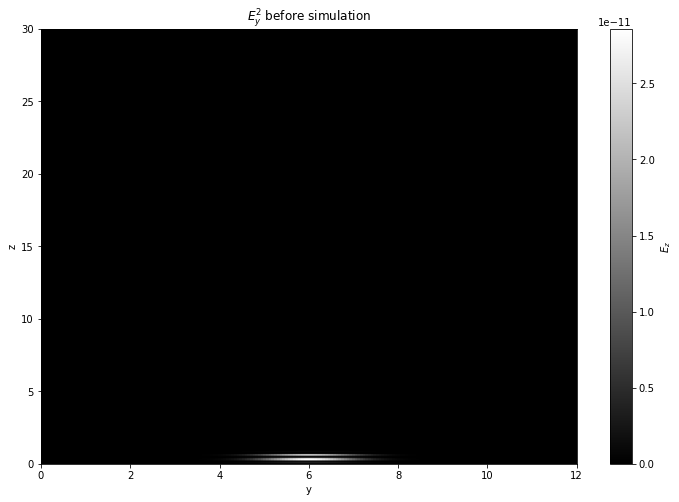

In [25]:
boundary = [[0,sim.box[1]],[0,sim.box[0]]]
plt.imshow( (eys[0].T)**2, interpolation = 'nearest', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')
plt.colorbar().set_label('$E_z$')
plt.xlabel("y")
plt.ylabel("z")
plt.title("$E_y^2$ before simulation")
plt.show()